<a href="https://colab.research.google.com/github/pra1608/quality-Prediction-in-mining/blob/main/LSTM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/cleaned.pkl')



In [ ]:
df = df.set_index(['datetime'])

In [ ]:
df

,date,year,month,day,hour,minute,second,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-30 00:00:00,2017-03-30 00:00:00,2017,3,30,0,0,0,59.54,9.56,1908.12,533.542,401.045,9.60323,1.72484,199.558,195.234,201.326,295.096,306.400,250.002,250.767,855.130039,821.072299,878.547321,459.554,592.059,551.010,522.392,66.36,1.69
2017-03-30 00:00:20,2017-03-30 00:00:00,2017,3,30,0,0,20,59.54,9.56,1894.65,533.922,400.325,9.60346,1.72505,199.561,194.898,201.855,295.096,306.400,250.000,250.757,855.129135,821.090690,878.661714,441.190,592.457,559.622,512.828,66.36,1.69
2017-03-30 00:00:40,2017-03-30 00:00:00,2017,3,30,0,0,40,59.54,9.56,1895.93,533.001,398.791,9.60369,1.72526,199.937,196.684,201.051,295.096,306.400,249.668,252.629,855.128230,821.109080,878.776107,453.158,590.323,548.417,501.807,66.36,1.69
2017-03-30 00:01:00,2017-03-30 00:00:00,2017,3,30,0,1,0,59.54,9.56,1876.59,534.324,396.910,9.60392,1.72547,199.819,196.919,199.288,295.096,306.400,250.138,250.395,855.127326,821.127471,878.890500,462.899,584.949,558.436,503.901,66.36,1.69
2017-03-30 00:01:20,2017-03-30 00:00:00,2017,3,30,0,1,20,59.54,9.56,1859.19,534.741,395.766,9.60415,1.72568,199.796,196.837,198.554,295.096,306.400,250.456,249.246,855.126421,821.145861,879.004893,476.801,581.155,560.810,507.434,66.36,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 23:58:20,2017-09-09 23:00:00,2017,9,9,23,58,20,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,299.163,299.920,299.623,346.794,313.695,392.160000,430.702000,872.008000,418.725,497.548,446.357,416.892,64.27,1.71
2017-09-09 23:58:40,2017-09-09 23:00:00,2017,9,9,23,58,40,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,299.487,299.710,300.465,330.023,236.700,401.505000,404.616000,864.409000,418.377,506.398,372.995,426.337,64.27,1.71
2017-09-09 23:59:00,2017-09-09 23:00:00,2017,9,9,23,59,0,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,299.487,299.927,299.707,329.590,225.879,408.899000,399.316000,867.598000,419.531,503.414,336.035,433.130,64.27,1.71


##Data Preprocessing
Here we are picking 708480 data points for training. Observation is recorded every ~20 sec, that means 3 times per minute. 

We are tracking data from past 60 timestamps (60/3=20 minute). This data will be used to predict the temperature after 3 timestamps (3/3=1 minute).

Since every feature has values with varying ranges, we do normalization to confine feature values to a range of [0, 1] before training a neural network. We do this by subtracting the mean and dividing by the standard deviation of each feature.

80 % of the data will be used to train the model, i.e. 566784 rows. split_fraction can be changed to alter this percentage.


In [ ]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))
step = 3

past = 60
future = 3
learning_rate = 0.0001
batch_size = 256
epochs = 3

In [ ]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [ ]:
df.columns

Index(['date', 'year', 'month', 'day', 'hour', 'minute', 'second',
       '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [ ]:
df.columns[8:-2].tolist()

['% Silica Feed',
 'Starch Flow',
 'Amina Flow',
 'Ore Pulp Flow',
 'Ore Pulp pH',
 'Ore Pulp Density',
 'Flotation Column 01 Air Flow',
 'Flotation Column 02 Air Flow',
 'Flotation Column 03 Air Flow',
 'Flotation Column 04 Air Flow',
 'Flotation Column 05 Air Flow',
 'Flotation Column 06 Air Flow',
 'Flotation Column 07 Air Flow',
 'Flotation Column 01 Level',
 'Flotation Column 02 Level',
 'Flotation Column 03 Level',
 'Flotation Column 04 Level',
 'Flotation Column 05 Level',
 'Flotation Column 06 Level',
 'Flotation Column 07 Level']

In [ ]:
selected_features = df.columns[8:].tolist()
features = df[selected_features]
features.head()



,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
datetime,,,,,,,,,,,,,,,,,,,,,,
2017-03-30 00:00:00,9.56,1908.12,533.542,401.045,9.60323,1.72484,199.558,195.234,201.326,295.096,306.4,250.002,250.767,855.130039,821.072299,878.547321,459.554,592.059,551.010,522.392,66.36,1.69
2017-03-30 00:00:20,9.56,1894.65,533.922,400.325,9.60346,1.72505,199.561,194.898,201.855,295.096,306.4,250.000,250.757,855.129135,821.090690,878.661714,441.190,592.457,559.622,512.828,66.36,1.69
2017-03-30 00:00:40,9.56,1895.93,533.001,398.791,9.60369,1.72526,199.937,196.684,201.051,295.096,306.4,249.668,252.629,855.128230,821.109080,878.776107,453.158,590.323,548.417,501.807,66.36,1.69
2017-03-30 00:01:00,9.56,1876.59,534.324,396.910,9.60392,1.72547,199.819,196.919,199.288,295.096,306.4,250.138,250.395,855.127326,821.127471,878.890500,462.899,584.949,558.436,503.901,66.36,1.69
2017-03-30 00:01:20,9.56,1859.19,534.741,395.766,9.60415,1.72568,199.796,196.837,198.554,295.096,306.4,250.456,249.246,855.126421,821.145861,879.004893,476.801,581.155,560.810,507.434,66.36,1.69


In [ ]:
features

,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
datetime,,,,,,,,,,,,,,,,,,,,,,
2017-03-30 00:00:00,9.56,1908.12,533.542,401.045,9.60323,1.72484,199.558,195.234,201.326,295.096,306.400,250.002,250.767,855.130039,821.072299,878.547321,459.554,592.059,551.010,522.392,66.36,1.69
2017-03-30 00:00:20,9.56,1894.65,533.922,400.325,9.60346,1.72505,199.561,194.898,201.855,295.096,306.400,250.000,250.757,855.129135,821.090690,878.661714,441.190,592.457,559.622,512.828,66.36,1.69
2017-03-30 00:00:40,9.56,1895.93,533.001,398.791,9.60369,1.72526,199.937,196.684,201.051,295.096,306.400,249.668,252.629,855.128230,821.109080,878.776107,453.158,590.323,548.417,501.807,66.36,1.69
2017-03-30 00:01:00,9.56,1876.59,534.324,396.910,9.60392,1.72547,199.819,196.919,199.288,295.096,306.400,250.138,250.395,855.127326,821.127471,878.890500,462.899,584.949,558.436,503.901,66.36,1.69
2017-03-30 00:01:20,9.56,1859.19,534.741,395.766,9.60415,1.72568,199.796,196.837,198.554,295.096,306.400,250.456,249.246,855.126421,821.145861,879.004893,476.801,581.155,560.810,507.434,66.36,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 23:58:20,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,299.163,299.920,299.623,346.794,313.695,392.160000,430.702000,872.008000,418.725,497.548,446.357,416.892,64.27,1.71
2017-09-09 23:58:40,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,299.487,299.710,300.465,330.023,236.700,401.505000,404.616000,864.409000,418.377,506.398,372.995,426.337,64.27,1.71
2017-09-09 23:59:00,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,299.487,299.927,299.707,329.590,225.879,408.899000,399.316000,867.598000,419.531,503.414,336.035,433.130,64.27,1.71


In [ ]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [ ]:
train_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-0.668994,-0.719638,0.476354,0.208143,-0.637316,0.655866,-2.559247,-2.581396,-2.617558,-1.831182,1.890194,-1.471007,-1.481944,2.430046,2.169791,2.225197,0.452123,2.058016,1.451274,1.232376,1.154868,-0.569049
1,-0.668994,-0.730553,0.480567,0.104501,-0.636655,0.658792,-2.559148,-2.592395,-2.599675,-1.831182,1.890194,-1.471083,-1.482328,2.430039,2.169927,2.225934,0.240640,2.062929,1.551543,1.115754,1.154868,-0.569049
2,-0.668994,-0.729515,0.470357,-0.116312,-0.635993,0.661717,-2.546805,-2.533930,-2.626855,-1.831182,1.890194,-1.483596,-1.410411,2.430033,2.170062,2.226671,0.378465,2.036589,1.421083,0.981366,1.154868,-0.569049
3,-0.668994,-0.745186,0.485023,-0.387076,-0.635332,0.664643,-2.550679,-2.526237,-2.686456,-1.831182,1.890194,-1.465881,-1.496235,2.430026,2.170198,2.227409,0.490644,1.970257,1.537734,1.006900,1.154868,-0.569049
4,-0.668994,-0.759284,0.489646,-0.551750,-0.634671,0.667569,-2.551434,-2.528921,-2.711270,-1.831182,1.890194,-1.453895,-1.540376,2.430020,2.170334,2.228146,0.650742,1.923427,1.565374,1.049981,1.154868,-0.569049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566779,1.686074,0.164686,1.708951,2.144509,-0.580163,0.983559,0.752712,1.146926,0.784029,2.168990,-1.027497,-1.467728,-1.546061,-0.119619,-0.009031,-0.274411,0.446100,1.011985,1.253064,1.461523,-1.383322,1.542397
566780,1.686074,0.167295,1.725801,2.658254,-0.587609,0.990525,0.755961,0.902653,0.781291,2.168974,-1.027417,-1.460944,-1.527199,-0.116667,0.018107,-0.290956,0.182426,0.699679,0.659810,1.258666,-1.383322,1.542397
566781,1.686074,0.178930,1.732242,1.893179,-0.595055,0.997630,0.741550,0.552219,0.705091,2.168959,-1.027337,-1.456081,-1.412947,-0.136708,-0.017959,-0.294901,0.203293,0.412208,0.154052,1.026422,-1.383322,1.542397
566782,1.686074,0.180000,1.672834,1.718860,-0.602472,1.004736,0.744143,0.806051,0.647619,2.168943,-1.027256,-1.457551,-1.491817,-0.130407,-0.106971,-0.300598,0.505339,0.163914,0.121417,0.754012,-1.383322,1.542397


#Training dataset


In [ ]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(20)]].values
y_train = features.iloc[start:end][[21]]

sequence_length = int(past / step)

In [ ]:
x_train.shape

(566784, 20)

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

#Validation dataset


In [ ]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(20)]].values
y_val = features.iloc[label_start:][[21]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 20, 20)
Target shape: (256, 1)


In [ ]:
x_val

array([[ 1.68607356,  0.18431032,  1.61405862, ...,  0.54683449,
         0.64931925,  0.3160825 ],
       [ 1.68607356,  0.19002264,  1.57585764, ...,  0.73642497,
         1.05981449,  0.25578396],
       [ 1.68607356,  0.19095444,  1.59233084, ...,  0.9341002 ,
         1.36345079,  0.4746268 ],
       ...,
       [ 1.37056921,  0.67145394, -0.11413113, ...,  2.2509764 ,
        -0.40333085, -0.50570913],
       [ 1.37056921,  0.61948396, -0.27550422, ...,  1.33557284,
        -0.05422885, -0.35084737],
       [ 1.37056921, -1.1246623 , -0.59145493, ..., -0.00358271,
         0.1079457 , -0.16337928]])

#Training


In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 20, 20)]          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                6784      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,817
Trainable params: 6,817
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/3
2213/2214 [============================>.] - ETA: 0s - loss: 0.9140
Epoch 00001: val_loss improved from inf to 0.98544, saving model to model_checkpoint.h5
2214/2214 [==============================] - 125s 57ms/step - loss: 0.9141 - val_loss: 0.9854
Epoch 2/3
2213/2214 [============================>.] - ETA: 0s - loss: 0.8238
Epoch 00002: val_loss did not improve from 0.98544
2214/2214 [==============================] - 126s 57ms/step - loss: 0.8240 - val_loss: 0.9855
Epoch 3/3
2213/2214 [============================>.] - ETA: 0s - loss: 0.7945
Epoch 00003: val_loss did not improve from 0.98544
2214/2214 [==============================] - 128s 58ms/step - loss: 0.7948 - val_loss: 0.9929


We can visualize the loss with the function below. After one point, the loss stops decreasing.

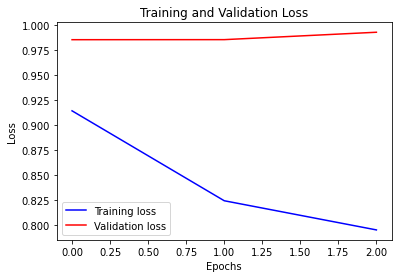

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

#Prediction
The trained model above is now able to make predictions for 5 sets of values from validation set.

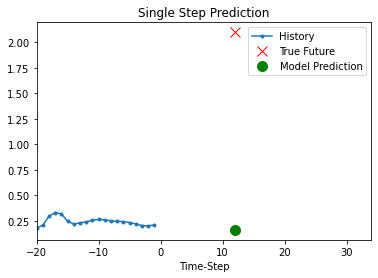

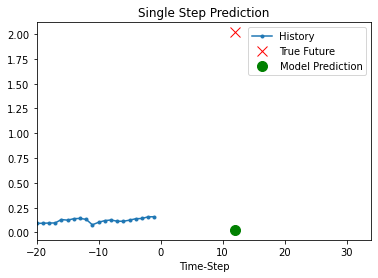

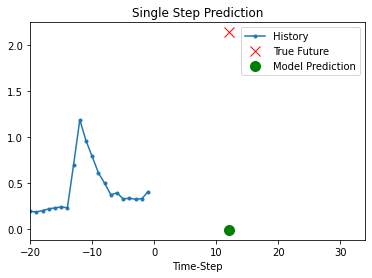

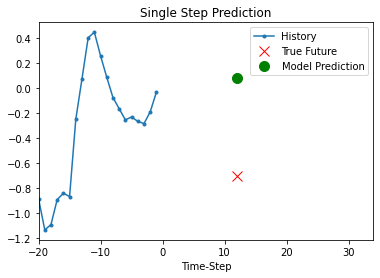

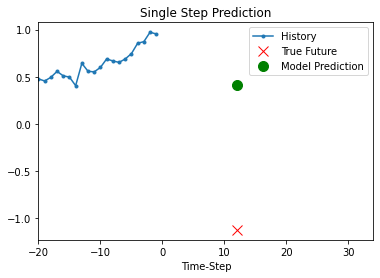

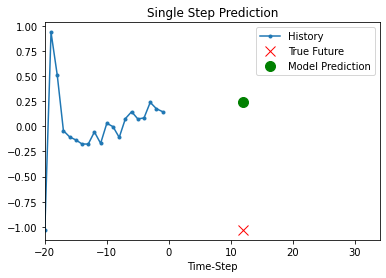

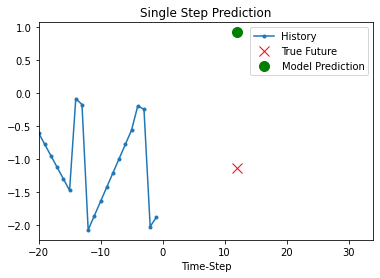

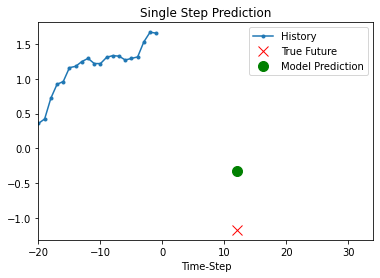

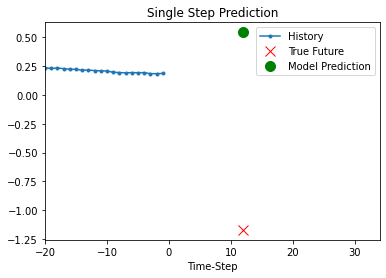

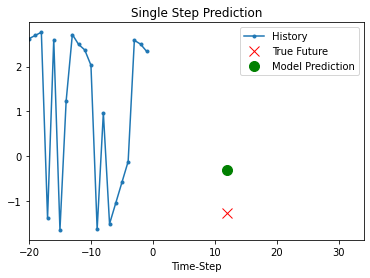

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(10):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )